In [1]:
!pip install -q gwpy
import nltk
nltk.download('punkt')
nltk.download('stopwords')
# !pip install rouge_score
# !pip install py7zr
# !pip install transformers
# !pip install datasets
# !pip install rouge
from typing import List
import os
import json
import ast
import pandas as pd
import csv
import argparse
import pickle
import transformers
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer
from datasets import load_dataset, load_from_disk
import numpy as np
from datasets import load_dataset, load_metric, load_from_disk
from transformers import pipeline
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from rouge import Rouge
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nahyun\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nahyun\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\Users\nahyun\anaconda3\envs\torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_parsed = pd.read_csv('./Results_csv/twcs_train.csv')

input_len = []
target_len = []

for i in range(len(train_parsed)):
    dialog_len = len(train_parsed.iloc[i]['dialog'])
    summary_len = len(train_parsed.iloc[i]['summary'])
    input_len.append(dialog_len)
    target_len.append(summary_len)

print(sum(input_len)/len(input_len))
print(sum(target_len)/len(target_len))

print(max(input_len))
print(max(target_len))

617.6221945137157
201.90274314214463
2848
515


In [3]:
max_input = 620
max_target = 202
# batch_size = 100
# model_name = "philschmid/distilbart-cnn-12-6-samsum"
model_name = "linydub/bart-large-samsum"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [4]:
def preprocess_data(data_to_process):
  #get all the dialogues  
  data_to_process['dialog'] = data_to_process['dialog'].astype('string')
  data_to_process['summary'] = data_to_process['summary'].astype('string')
  list_summary = list(data_to_process['summary'])
  inputs = [dialogue for dialogue in data_to_process['dialog']]
  #tokenize the dialogues
  model_inputs = tokenizer(inputs,  max_length=max_input, padding='max_length', truncation=True)
  #tokenize the summaries
  with tokenizer.as_target_tokenizer():
    targets = tokenizer(list_summary, max_length=max_target, padding='max_length', truncation=True)
  #set labels
  'id', 'dialogue', 'summary', 'input_ids', 'attention_mask', 'labels'
  model_inputs['labels'] = targets['input_ids']

  #return the tokenized data
  #input_ids, attention_mask and labels
  results = []
  for i in range (len(list(data_to_process['dialog']))):
    dic = {'dialogue':list(data_to_process['dialog'])[i], 'summary':list(data_to_process['summary'])[i],'input_ids':model_inputs['input_ids'][i], 'attention_mask':model_inputs['attention_mask'][i], 'labels':model_inputs['labels'][i]}
    results.append(dic)
  return results



In [5]:
train_parsed = pd.read_csv('./Results_csv/twcs_train.csv')
valid_parsed = pd.read_csv('./Results_csv/twcs_val.csv')
test_parsed = pd.read_csv('./Results_csv/twcs_test.csv')

preprocessed_train_data = preprocess_data(train_parsed)
preprocessed_valid_data = preprocess_data(valid_parsed)

C:\Users\nahyun\anaconda3\envs\torch\lib\site-packages\transformers\tokenization_utils_base.py:3546: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


In [6]:
preprocessed_train_data[0]

{'dialogue': '135060: So neither my iPhone nor my Apple Watch are recording my steps/activity, and Health doesn’t recognise either source anymore for some reason. Any ideas? https://t.co/m9DPQbkftD\nAppleSupport: @135060 Let’s investigate this together. To start, can you tell us the software versions your iPhone and Apple Watch are running currently?\n135060: @AppleSupport My iPhone is on 11.1.2, and my watch is on 4.1.\n',
 'summary': 'Customer enquired about his Iphone and Apple watch which is not showing his any steps/activity and health activities. Agent is asking to move to DM and look into it.',
 'input_ids': [0,
  1558,
  1096,
  2466,
  35,
  407,
  5063,
  127,
  2733,
  3486,
  127,
  1257,
  3075,
  32,
  5492,
  127,
  2402,
  73,
  30280,
  6,
  8,
  1309,
  630,
  17,
  27,
  90,
  11865,
  1169,
  1300,
  5988,
  13,
  103,
  1219,
  4,
  5053,
  2956,
  116,
  1205,
  640,
  90,
  4,
  876,
  73,
  119,
  466,
  5174,
  1864,
  428,
  330,
  2543,
  495,
  50118,
  2077

## Shuffle data

In [26]:
preprocessd_test_data = preprocess_data(test_parsed)




{'dialogue': '135060: So neither my iPhone nor my Apple Watch are recording my steps/activity, and Health doesn’t recognise either source anymore for some reason. Any ideas? https://t.co/m9DPQbkftD\nAppleSupport: @135060 Let’s investigate this together. To start, can you tell us the software versions your iPhone and Apple Watch are running currently?\n135060: @AppleSupport My iPhone is on 11.1.2, and my watch is on 4.1.\n',
 'summary': 'Customer enquired about his Iphone and Apple watch which is not showing his any steps/activity and health activities. Agent is asking to move to DM and look into it.',
 'input_ids': [0,
  1558,
  1096,
  2466,
  35,
  407,
  5063,
  127,
  2733,
  3486,
  127,
  1257,
  3075,
  32,
  5492,
  127,
  2402,
  73,
  30280,
  6,
  8,
  1309,
  630,
  17,
  27,
  90,
  11865,
  1169,
  1300,
  5988,
  13,
  103,
  1219,
  4,
  5053,
  2956,
  116,
  1205,
  640,
  90,
  4,
  876,
  73,
  119,
  466,
  5174,
  1864,
  428,
  330,
  2543,
  495,
  50118,
  2077

## rouge metric

In [7]:
# model_name="philschmid/distilbart-cnn-12-6-samsum"
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
metric = load_metric('rouge')
collator = transformers.DataCollatorForSeq2Seq(tokenizer, model=model)
def compute_rouge(pred):
  predictions, labels = pred
  #decode the predictions
  decode_predictions = tokenizer.batch_decode(predictions, skip_special_tokens=True)
  #decode labels
  decode_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

  #compute results
  res = metric.compute(predictions=decode_predictions, references=decode_labels, use_stemmer=True)
  #get %
  res = {key: value.mid.fmeasure * 100 for key, value in res.items()}

  pred_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
  res['gen_len'] = np.mean(pred_lens)

  return {k: round(v, 4) for k, v in res.items()}

C:\Users\nahyun\AppData\Local\Temp\ipykernel_3908\3065557357.py:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric('rouge')


## CALLBACK

In [8]:
import os
from transformers.integrations import TrainerCallback, is_tensorboard_available

def custom_rewrite_logs(d, mode):
    new_d = {}
    eval_prefix = "eval_"
    eval_prefix_len = len(eval_prefix)
    test_prefix = "test_"
    test_prefix_len = len(test_prefix)
    for k, v in d.items():
        if mode == 'eval' and k.startswith(eval_prefix):
            if k[eval_prefix_len:] == 'loss':
                new_d["combined/" + k[eval_prefix_len:]] = v
        elif mode == 'test' and k.startswith(test_prefix):
            if k[test_prefix_len:] == 'loss':
                new_d["combined/" + k[test_prefix_len:]] = v
        elif mode == 'train':
            if k == 'loss':
                new_d["combined/" + k] = v
    return new_d


class CombinedTensorBoardCallback(TrainerCallback):
    """
    A [`TrainerCallback`] that sends the logs to [TensorBoard](https://www.tensorflow.org/tensorboard).
    Args:
        tb_writer (`SummaryWriter`, *optional*):
            The writer to use. Will instantiate one if not set.
    """

    def __init__(self, tb_writers=None):
        has_tensorboard = is_tensorboard_available()
        if not has_tensorboard:
            raise RuntimeError(
                "TensorBoardCallback requires tensorboard to be installed. Either update your PyTorch version or"
                " install tensorboardX."
            )
        if has_tensorboard:
            try:
                from torch.utils.tensorboard import SummaryWriter  # noqa: F401

                self._SummaryWriter = SummaryWriter
            except ImportError:
                try:
                    from tensorboardX import SummaryWriter

                    self._SummaryWriter = SummaryWriter
                except ImportError:
                    self._SummaryWriter = None
        else:
            self._SummaryWriter = None
        self.tb_writers = tb_writers

    def _init_summary_writer(self, args, log_dir=None):
        log_dir = log_dir or args.logging_dir
        if self._SummaryWriter is not None:
            self.tb_writers = dict(train=self._SummaryWriter(log_dir=os.path.join(log_dir, 'train')),
                                   eval=self._SummaryWriter(log_dir=os.path.join(log_dir, 'eval')))

    def on_train_begin(self, args, state, control, **kwargs):
        if not state.is_world_process_zero:
            return

        log_dir = None

        if state.is_hyper_param_search:
            trial_name = state.trial_name
            if trial_name is not None:
                log_dir = os.path.join(args.logging_dir, trial_name)

        if self.tb_writers is None:
            self._init_summary_writer(args, log_dir)

        for k, tbw in self.tb_writers.items():
            tbw.add_text("args", args.to_json_string())
            if "model" in kwargs:
                model = kwargs["model"]
                if hasattr(model, "config") and model.config is not None:
                    model_config_json = model.config.to_json_string()
                    tbw.add_text("model_config", model_config_json)
            # Version of TensorBoard coming from tensorboardX does not have this method.
            if hasattr(tbw, "add_hparams"):
                tbw.add_hparams(args.to_sanitized_dict(), metric_dict={})

    def on_log(self, args, state, control, logs=None, **kwargs):
        if not state.is_world_process_zero:
            return

        if self.tb_writers is None:
            self._init_summary_writer(args)

        for tbk, tbw in self.tb_writers.items():
            logs_new = custom_rewrite_logs(logs, mode=tbk)
            for k, v in logs_new.items():
                if isinstance(v, (int, float)):
                    tbw.add_scalar(k, v, state.global_step)
                else:
                    logger.warning(
                        "Trainer is attempting to log a value of "
                        f'"{v}" of type {type(v)} for key "{k}" as a scalar. '
                        "This invocation of Tensorboard's writer.add_scalar() "
                        "is incorrect so we dropped this attribute."
                    )
            tbw.flush()

    def on_train_end(self, args, state, control, **kwargs):
        for tbw in self.tb_writers.values():
            tbw.close()
        self.tb_writers = None


In [9]:
from transformers import EarlyStoppingCallback

early_stopping = EarlyStoppingCallback(early_stopping_patience= 3, 
                                    early_stopping_threshold= 0.001)

## Train

In [10]:
# !pip install wandb
import wandb

In [6]:
output_dir = './training-log/bart-5/'

In [12]:
output_dir = './training-log/bart-5/'

args = Seq2SeqTrainingArguments(
    output_dir=output_dir,
    evaluation_strategy='steps',
    learning_rate=2e-7,
    auto_find_batch_size=True,
    per_device_train_batch_size=3,
    per_device_eval_batch_size=3,
    gradient_accumulation_steps=2,
    weight_decay=0.0001,
    save_total_limit=2,
    num_train_epochs=20,
    predict_with_generate=True,
    eval_accumulation_steps=3,
    fp16=True,
    overwrite_output_dir= True,
    load_best_model_at_end = True,
    save_strategy='steps',
    report_to="wandb",
    seed=42
    )

trainer = Seq2SeqTrainer(
    model, 
    args,
    train_dataset=preprocessed_train_data,
    eval_dataset=preprocessed_valid_data,
    data_collator=collator,
    tokenizer=tokenizer,
    compute_metrics=compute_rouge,
    callbacks=[CombinedTensorBoardCallback, early_stopping]
)

Using cuda_amp half precision backend


In [13]:
##### %%wandb
trainer.train()

C:\Users\nahyun\anaconda3\envs\torch\lib\site-packages\accelerate\memory_utils.py:23: FutureWarning: memory_utils has been reorganized to utils.memory. Import `find_executable_batchsize` from the main `__init__`: `from accelerate import find_executable_batch_size` to avoid this warning.
  warnings.warn(
C:\Users\nahyun\anaconda3\envs\torch\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 2406
  Num Epochs = 20
  Instantaneous batch size per device = 3
  Total train batch size (w. parallel, distributed & accumulation) = 6
  Gradient Accumulation steps = 2
  Total optimization steps = 8020
  Number of trainable parameters = 406291456
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB

The following columns in the training set don't have a corresponding argument in `BartForConditionalGeneration.forward` and have been ignored: summary, dialogue. If summary, dialogue are not expected by `BartForConditionalGeneration.forward`,  you can safely ignore this message.
You're using a BartTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
500,10.690200,8.474370,38.171500,17.317500,30.895700,30.833100,41.559600
1000,7.231700,6.019929,43.227400,19.607700,35.690800,35.645600,46.868500
1500,6.130100,5.577246,46.573600,22.816200,39.072300,38.983700,50.110100
2000,5.781500,5.365711,48.337200,24.415000,40.974100,40.874100,50.162100
2500,5.568400,5.227052,48.829300,24.753500,41.393900,41.325900,49.709500
3000,5.427000,5.119960,49.573300,25.451200,42.293400,42.203300,49.061200
3500,5.287400,5.024884,49.882700,25.867100,42.720900,42.677900,48.522900
4000,5.184300,4.942989,50.002700,25.947500,42.879100,42.835100,48.091700
4500,5.099800,4.872396,49.993700,26.072300,42.974300,42.903100,48.137600
5000,5.012500,4.809988,49.871100,26.119200,42.911500,42.869400,47.963300


***** Running Evaluation *****
  Num examples = 327
  Batch size = 3
The following columns in the evaluation set don't have a corresponding argument in `BartForConditionalGeneration.forward` and have been ignored: summary, dialogue. If summary, dialogue are not expected by `BartForConditionalGeneration.forward`,  you can safely ignore this message.
Saving model checkpoint to ./training-log/bart-5/checkpoint-500
Configuration saved in ./training-log/bart-5/checkpoint-500\config.json
Model weights saved in ./training-log/bart-5/checkpoint-500\pytorch_model.bin
tokenizer config file saved in ./training-log/bart-5/checkpoint-500\tokenizer_config.json
Special tokens file saved in ./training-log/bart-5/checkpoint-500\special_tokens_map.json
***** Running Evaluation *****
  Num examples = 327
  Batch size = 3
The following columns in the evaluation set don't have a corresponding argument in `BartForConditionalGeneration.forward` and have been ignored: summary, dialogue. If summary, dialogue a

***** Running Evaluation *****
  Num examples = 327
  Batch size = 3
The following columns in the evaluation set don't have a corresponding argument in `BartForConditionalGeneration.forward` and have been ignored: summary, dialogue. If summary, dialogue are not expected by `BartForConditionalGeneration.forward`,  you can safely ignore this message.
Saving model checkpoint to ./training-log/bart-5/checkpoint-5500
Configuration saved in ./training-log/bart-5/checkpoint-5500\config.json
Model weights saved in ./training-log/bart-5/checkpoint-5500\pytorch_model.bin
tokenizer config file saved in ./training-log/bart-5/checkpoint-5500\tokenizer_config.json
Special tokens file saved in ./training-log/bart-5/checkpoint-5500\special_tokens_map.json
Deleting older checkpoint [training-log\bart-5\checkpoint-4500] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 327
  Batch size = 3
The following columns in the evaluation set don't have a corresponding argument in `Bart

TrainOutput(global_step=8020, training_loss=5.655690958493963, metrics={'train_runtime': 5468.4971, 'train_samples_per_second': 8.799, 'train_steps_per_second': 1.467, 'total_flos': 6.31389311926272e+16, 'train_loss': 5.655690958493963, 'epoch': 20.0})

In [23]:
output_dir='./models/bart-5'

model = AutoModelForSeq2SeqLM.from_pretrained('./models/bart-5/')

args = Seq2SeqTrainingArguments(
    output_dir=output_dir,
    evaluation_strategy='steps',
    learning_rate=2e-7,
    auto_find_batch_size=True,
    per_device_train_batch_size=3,
    per_device_eval_batch_size=3,
    gradient_accumulation_steps=2,
    weight_decay=0.0001,
    save_total_limit=2,
    num_train_epochs=20,
    predict_with_generate=True,
    eval_accumulation_steps=3,
    fp16=True,
    overwrite_output_dir= True,
    load_best_model_at_end = True,
    save_strategy='steps',
    report_to="wandb",
    seed=42
    )

trainer = Seq2SeqTrainer(
    model, 
    args,
    train_dataset=preprocessed_train_data,
    eval_dataset=preprocessed_valid_data,
#     data_collator=collator,
    tokenizer=tokenizer,
    compute_metrics=compute_rouge,
    callbacks=[CombinedTensorBoardCallback, early_stopping]
)

##### %%wandb
# trainer.train()

loading configuration file ./models/bart-5/config.json
Model config BartConfig {
  "_name_or_path": "./models/bart-5/",
  "_num_labels": 3,
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_bias_logits": false,
  "add_final_layer_norm": false,
  "architectures": [
    "BartForConditionalGeneration"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classif_dropout": 0.0,
  "classifier_dropout": 0.0,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 12,
  "decoder_start_token_id": 2,
  "dropout": 0.1,
  "early_stopping": true,
  "encoder_attention_heads": 16,
  "encoder_ffn_dim": 4096,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 12,
  "eos_token_id": 2,
  "eos_token_ids": [
    2
  ],
  "forced_eos_token_id": 2,
  "gradient_checkpointing": false,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "init_std": 0.02,
  "is_encoder_decoder": true,
  "label

In [12]:
# trainer.save_model('./models/bart-5/')

In [ ]:
# plotting using tensorboard
# %load_ext tensorboard
# %tensorboard --logdir training-log/bart/runs

In [24]:
predicted_sum = []
for test_dialog in test_parsed['dialog']:
  model_inputs = tokenizer(test_dialog,  max_length=max_input, padding='max_length', truncation=True)
  raw_pred, _, _ = trainer.predict([model_inputs])
  predicted_sum.append(tokenizer.decode(raw_pred[0]))

***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


***** Running Prediction *****
  Num examples = 1
  Batch size = 3


In [25]:
cleaned_data = []
for summary in predicted_sum:
  summary= summary.replace('</s>', '')
  summary= summary.replace('<s>', '')
  summary= summary.replace('<pad>', '')
  cleaned_data.append(summary)

In [26]:
test_parsed['finetuned_predicted'] = cleaned_data

In [27]:
summaries = list(test_parsed['summary'])

rouge = Rouge()
rouge.get_scores(list(test_parsed['finetuned_predicted']), summaries, avg=True)

{'rouge-1': {'r': 0.4738073266877376,
  'p': 0.43975257088964653,
  'f': 0.4461211256664116},
 'rouge-2': {'r': 0.2210733286740097,
  'p': 0.21420516146898858,
  'f': 0.21063012684483115},
 'rouge-l': {'r': 0.4443579233029028,
  'p': 0.41197299731042186,
  'f': 0.41798705969027306}}

In [28]:
# test_parsed.to_csv("predicted_with_bart_5.csv")

In [29]:
def generation_Rouge_Scores(X, Y):  
  rouge = Rouge()
  return rouge.get_scores(X, Y)

def get_rouge1_rouge2_scores_for_bxplot(test_parsed):
  Rouge_1_f1scores_list = []
  Rouge_2_f1scores_list = []
  Rouge_1_precision_list = []
  Rouge_2_precision_list = []
  Rouge_1_recall_list = []
  Rouge_2_recall_list = []
  for i in range(len(test_parsed)):
    X = test_parsed['summary'][i]
    Y = test_parsed['finetuned_predicted'][i]
    get_rouge_scores = generation_Rouge_Scores(X,Y)
    Rouge_1_f1scores = get_rouge_scores[0]['rouge-1']['f']
    Rouge_2_f1scores = get_rouge_scores[0]['rouge-2']['f']

    Rouge_1_f1scores_list.append(Rouge_1_f1scores)
    Rouge_2_f1scores_list.append(Rouge_2_f1scores)

    Rouge_1_precision = get_rouge_scores[0]['rouge-1']['p']
    Rouge_2_precision = get_rouge_scores[0]['rouge-2']['p']

    Rouge_1_precision_list.append(Rouge_1_precision)
    Rouge_2_precision_list.append(Rouge_2_precision)

    Rouge_1_recall = get_rouge_scores[0]['rouge-1']['r']
    Rouge_2_recall = get_rouge_scores[0]['rouge-2']['r']

    Rouge_1_recall_list.append(Rouge_1_recall)
    Rouge_2_recall_list.append(Rouge_2_recall)
  return Rouge_1_f1scores_list, Rouge_2_f1scores_list

In [30]:
Rouge_1_f1scores_finetuned_CNN, Rouge_2_f1scores_finetuned_CNN = get_rouge1_rouge2_scores_for_bxplot(test_parsed)
print("Max for Rouge_1 f1 scores    : ", np.max(Rouge_1_f1scores_finetuned_CNN))
print("Min for Rouge_1 f1 scores    : ", np.min(Rouge_1_f1scores_finetuned_CNN))
print("Mean for Rouge_1 f1 scores   : ", np.mean(Rouge_1_f1scores_finetuned_CNN))
print("Median for Rouge_1 f1 scores : ", np.median(Rouge_1_f1scores_finetuned_CNN))

Max for Rouge_1 f1 scores    :  0.8421052581717452
Min for Rouge_1 f1 scores    :  0.09999999505000023
Mean for Rouge_1 f1 scores   :  0.4461211256664115
Median for Rouge_1 f1 scores :  0.4363636316429752


<AxesSubplot: title={'center': 'Rouge 1 f1 scores for bart model'}>

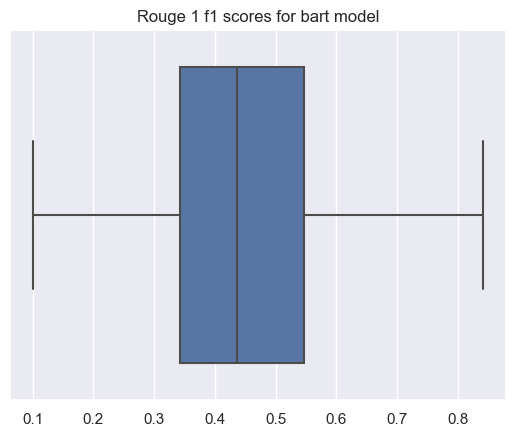

In [31]:
sns.set(style="darkgrid")
plt.title("Rouge 1 f1 scores for bart model")
sns.boxplot(x=Rouge_1_f1scores_finetuned_CNN)

In [32]:
print("Max for Rouge_2 f1 scores    : ", np.max(Rouge_2_f1scores_finetuned_CNN))
print("Min for Rouge_2 f1 scores    : ", np.min(Rouge_2_f1scores_finetuned_CNN))
print("Mean for Rouge_2 f1 scores   : ", np.mean(Rouge_2_f1scores_finetuned_CNN))
print("Median for Rouge_2 f1 scores : ", np.median(Rouge_2_f1scores_finetuned_CNN))

Max for Rouge_2 f1 scores    :  0.679999995288
Min for Rouge_2 f1 scores    :  0.0
Mean for Rouge_2 f1 scores   :  0.21063012684483126
Median for Rouge_2 f1 scores :  0.1797752761267518


<AxesSubplot: title={'center': 'Rouge 2 f1 scores for bart model'}>

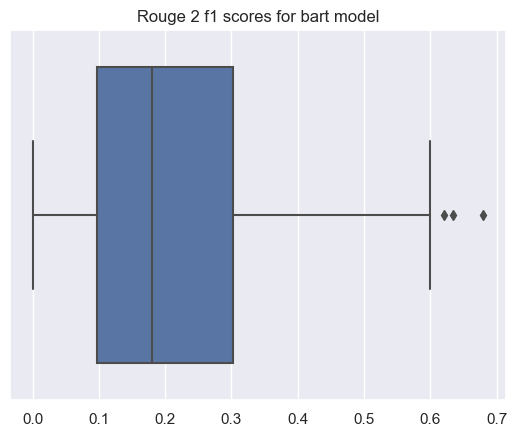

In [33]:
sns.set(style="darkgrid")
plt.title("Rouge 2 f1 scores for bart model")
sns.boxplot(x=Rouge_2_f1scores_finetuned_CNN)